# Stellar Classification

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

# Load and Check Data
## SDSS Astronomical Dataset - Feature Description
This dataset consists of **100,000 astronomical observations** collected by the **Sloan Digital Sky Survey (SDSS)**. Each observation contains **17 features** describing the object and **1 class label** indicating whether the object is a **star**, **galaxy**, or **quasar**.

## 📦 Dataset Columns

| Column Name      | Description |
|------------------|-------------|
| `obj_ID`         | Object Identifier — a unique ID for the object in the image catalog used by the CAS |
| `alpha`          | Right Ascension angle (at J2000 epoch) |
| `delta`          | Declination angle (at J2000 epoch) |
| `u`              | Ultraviolet filter magnitude in the photometric system |
| `g`              | Green filter magnitude in the photometric system |
| `r`              | Red filter magnitude in the photometric system |
| `i`              | Near Infrared filter magnitude in the photometric system |
| `z`              | Infrared filter magnitude in the photometric system |
| `run_ID`         | Run Number — identifies the specific scan |
| `rerun_ID`       | Rerun Number — specifies how the image was processed |
| `cam_col`        | Camera column — identifies the scanline within the run |
| `field_ID`       | Field number — identifies each field |
| `spec_obj_ID`    | Spectroscopic Object ID — unique for optical spectroscopic observations<br>**Note:** Two different observations with the same `spec_obj_ID` must have the same class label |
| `class`          | Object class — one of: `GALAXY`, `STAR`, `QSO` (quasar) |
| `redshift`       | Redshift value — indicates the increase in wavelength |
| `plate`          | Plate ID — identifies each plate in the SDSS |
| `MJD`            | Modified Julian Date — indicates the date the data was taken |
| `fiber_ID`       | Fiber ID — identifies the fiber that pointed the light at the focal plane |



In [279]:
file_path = 'Data\\star_classification.csv'
Stars_df = pd.read_csv(filepath_or_buffer=file_path)
Stars_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [280]:
Stars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [281]:
Stars_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [282]:
a, b, c = Stars_df["class"].value_counts() / len(Stars_df)
print(f"Total percentage of Galaxies : {round(a*100, 1)}%")
print(f"Total percentage of Stars : {round(b*100, 1)}%")
print(f"Total percentage of QSO : {round(c*100, 1)}%")

Total percentage of Galaxies : 59.4%
Total percentage of Stars : 21.6%
Total percentage of QSO : 19.0%


C:\Users\Gabri\AppData\Local\Temp\ipykernel_18216\3580316416.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = Stars_df["class"], palette="Set3")


<Axes: xlabel='class', ylabel='count'>

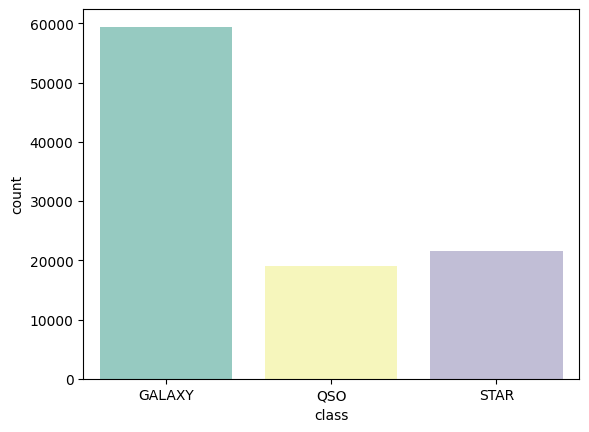

In [283]:
sns.countplot(x = Stars_df["class"], palette="Set3")

# Visualization of Data

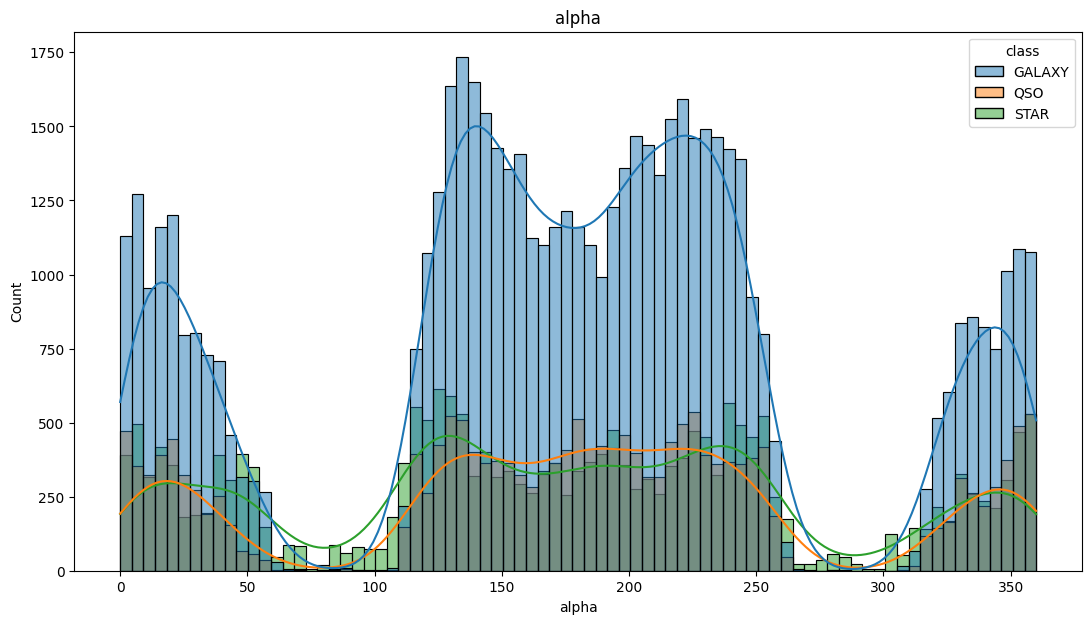

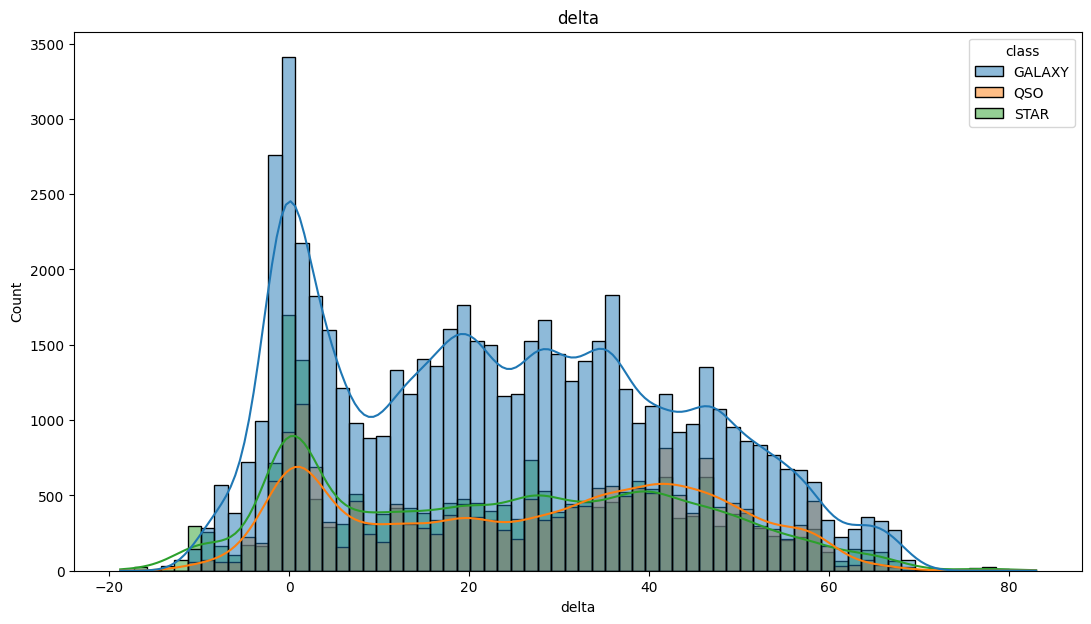

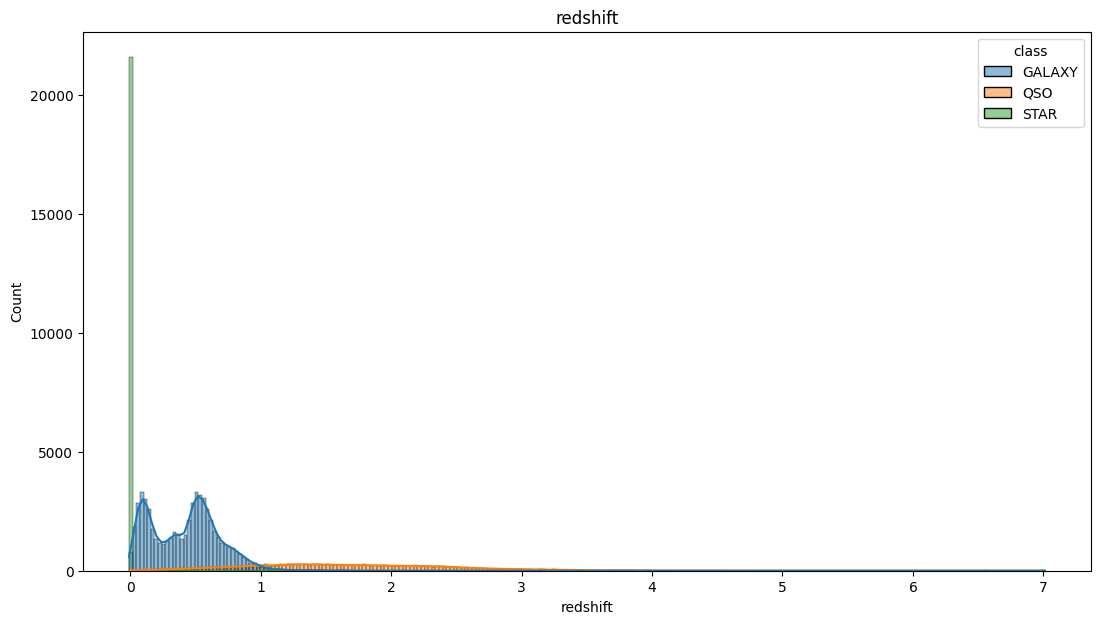

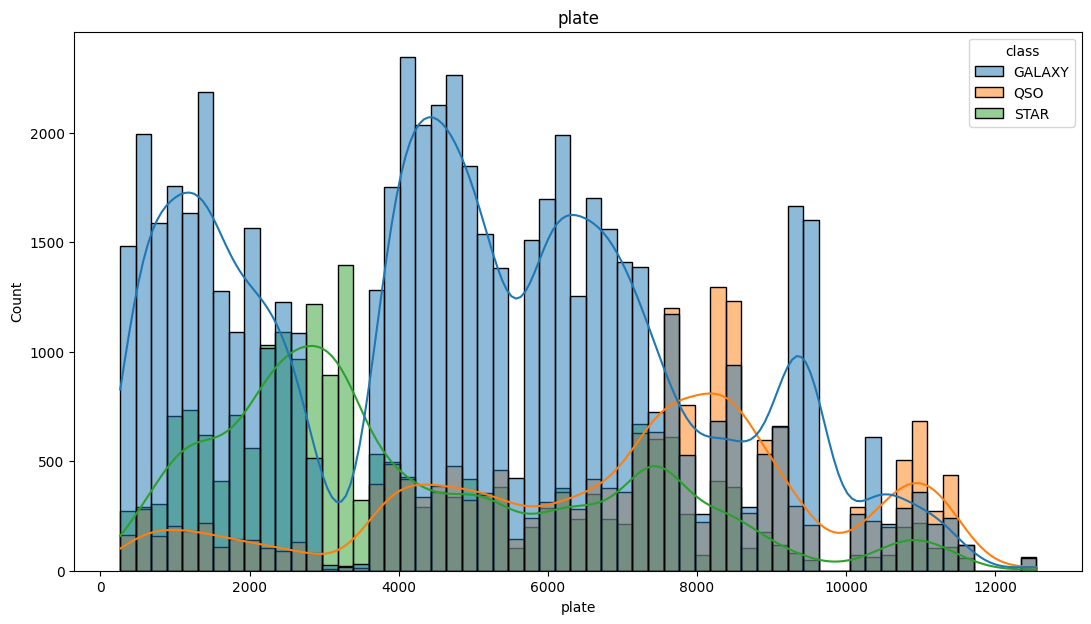

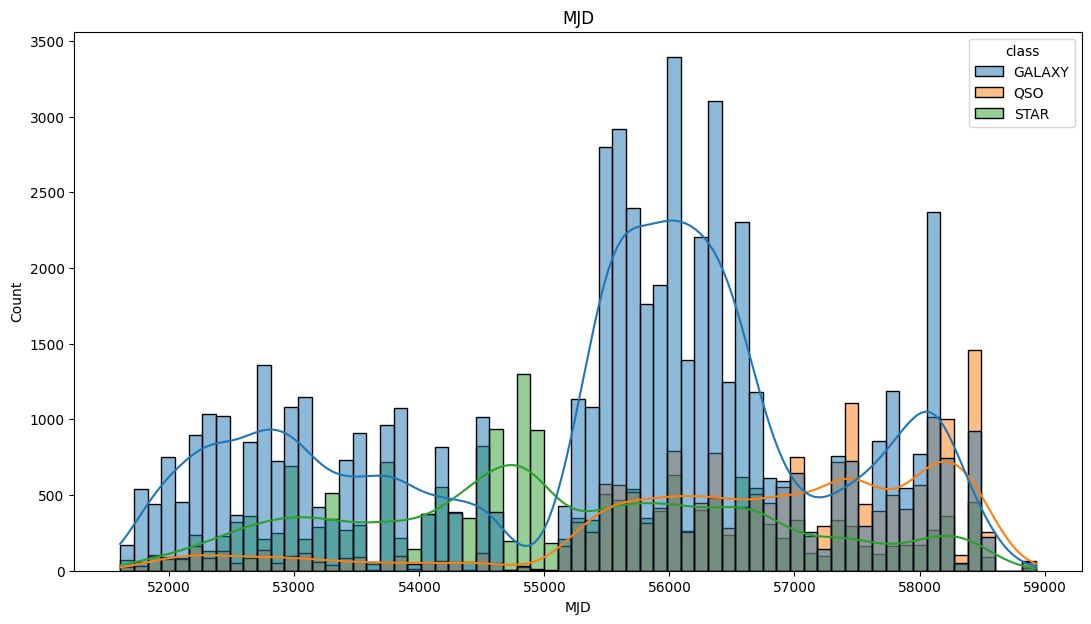

In [284]:
#We can train out models faster if we choose those features which can distinguish well between out classes.....
#As alpha, delta, u, g, r, i, z, redshift, plate, MJD are astronomical quantities, therefore, we'll keep them as our primary feature...


for i in ['alpha', 'delta','redshift', 'plate', 'MJD']:
    plt.figure(figsize=(13,7))
    sns.histplot(data=Stars_df, x=i, kde=True, hue="class")
    plt.title(i)
    plt.show()

In [285]:
# Now i'll use KDE to visualise the photometric filters which are u, g, r, i, z

from sklearn.calibration import LabelEncoder


le = LabelEncoder()
Stars_df["class"] = le.fit_transform(Stars_df["class"])
Stars_df["class"] = Stars_df["class"].astype(int)

def plot(column):
    for i in range(3):
        sns.kdeplot(data=Stars_df[Stars_df["class"] == i][column], label = le.inverse_transform([i]), fill = True)
    sns.kdeplot(data=Stars_df[column],label = ["All"], fill = True)
    plt.legend()
    
def log_plot(column):
    for i in range(3):
        sns.kdeplot(data=np.log(Stars_df[Stars_df["class"] == i][column]), label = le.inverse_transform([i]), fill = True)
    sns.kdeplot(data=np.log(Stars_df[column]),label = ["All"], fill = True)
    plt.legend() 

c:\Users\Gabri\Documents\GitHub\Stellar-Classification\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Gabri\Documents\GitHub\Stellar-Classification\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


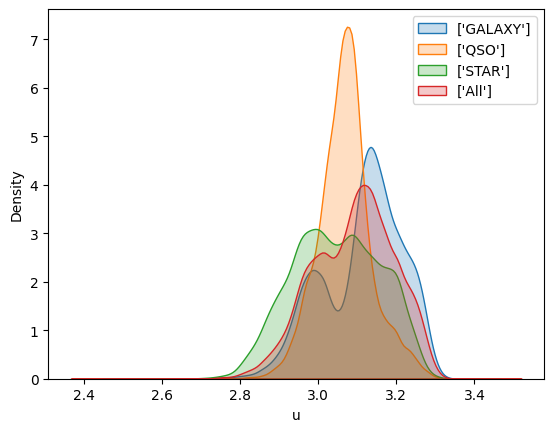

In [286]:
#I'll apply log due to extreme values
log_plot('u')

c:\Users\Gabri\Documents\GitHub\Stellar-Classification\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Gabri\Documents\GitHub\Stellar-Classification\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


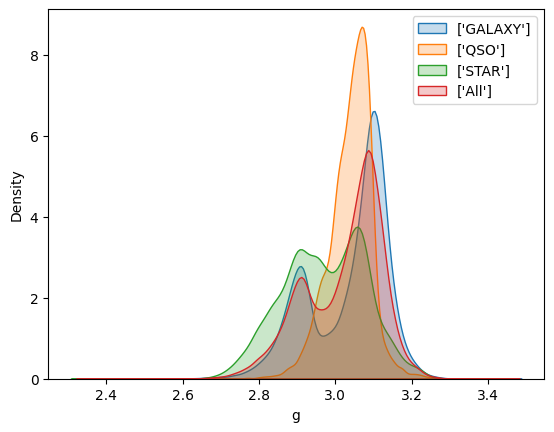

In [287]:
#I'll apply log due to extreme values
log_plot('g')

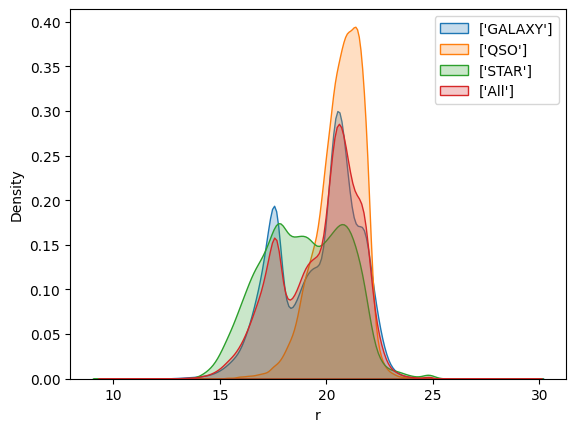

In [288]:
plot('r')

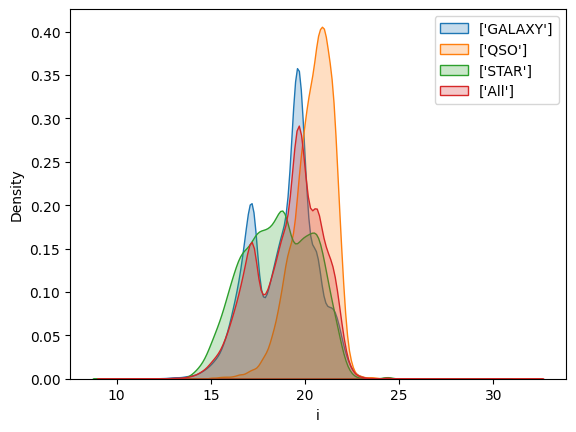

In [289]:
plot('i')

c:\Users\Gabri\Documents\GitHub\Stellar-Classification\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Gabri\Documents\GitHub\Stellar-Classification\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


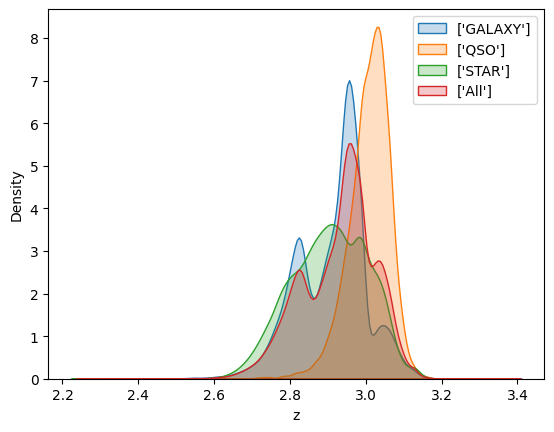

In [290]:
log_plot('z')

Text(0.5, 1.0, ' stellar correlation matrix')

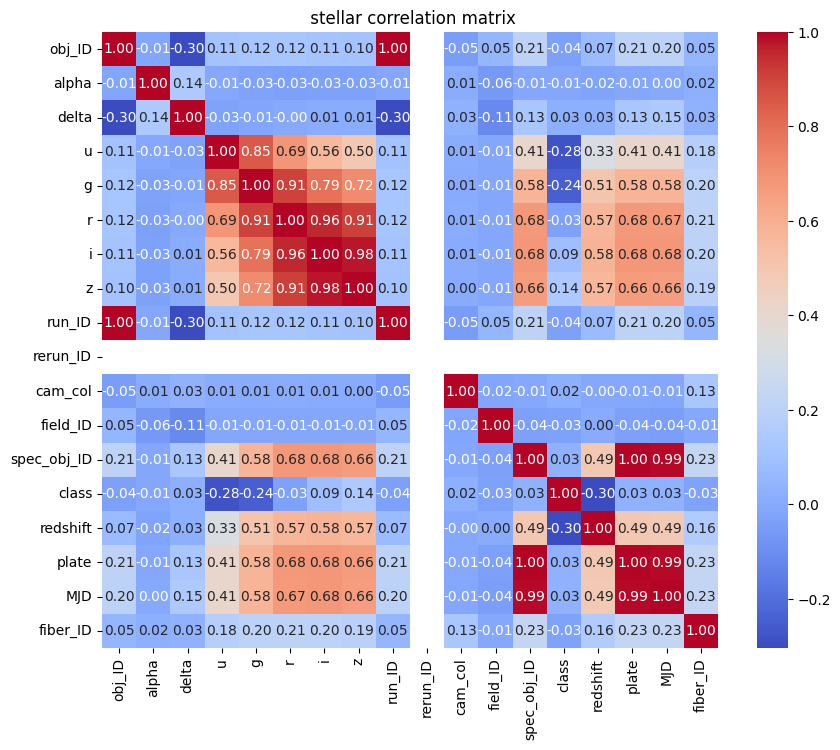

In [291]:
corr_matt=Stars_df.corr(method="spearman")
plt.figure(figsize=(10,8))
sns.heatmap(corr_matt,annot=True,fmt="0.2f",cmap="coolwarm",square=True)
plt.title(" stellar correlation matrix")

Decodation of labels

In [292]:
Stars_df["class"] = le.inverse_transform(Stars_df["class"])
Stars_df['class']

0        GALAXY
1        GALAXY
2        GALAXY
3        GALAXY
4        GALAXY
          ...  
99995    GALAXY
99996    GALAXY
99997    GALAXY
99998    GALAXY
99999    GALAXY
Name: class, Length: 100000, dtype: object

# Data Cleaning

In [293]:
#Sometimes due to outliers, we can't do good analysis of our data therefore, we decided to remove them as our current dataset contains aloooooooooooot of outliers

def rem_outliers():
    s1 = Stars_df.shape

    for i in Stars_df.select_dtypes(include = 'number').columns:
        qt1 = Stars_df[i].quantile(0.25)
        qt3 = Stars_df[i].quantile(0.75)
        iqr =  qt3 - qt1
        lower = qt1-(1.5*iqr)
        upper = qt3+(1.5*iqr)
        min_in = Stars_df[Stars_df[i]<lower].index
        max_in = Stars_df[Stars_df[i]>upper].index
        Stars_df.drop(min_in, inplace = True)
        Stars_df.drop(max_in, inplace = True)
    
    s2 = Stars_df.shape
    outliers = s1[0] - s2[0]
    return outliers

In [294]:
print('Number of outliners deleted: ', rem_outliers())

Number of outliners deleted:  14266


# Data modeling

Features selection 

In [295]:
Stars_df = Stars_df[['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'plate', 'MJD', 'class']]

X = Stars_df.drop(columns='class', axis=1)
y = Stars_df['class']

Train/test split

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Creating pipelines for modeling 

In [297]:
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals 
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

#Preprocesor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

#pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True)

Initialaizing GridSerachCV

In [298]:
'''
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2)
grid_search.fit(X_train,y_train)
'''

"\nparam_grid = {\n    'classifier__n_estimators': [50, 100],\n    'classifier__max_depth': [None, 20],\n    'classifier__min_samples_split': [2, 5]\n}\n\ngrid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2)\ngrid_search.fit(X_train,y_train)\n"

RandomSearchCV

In [299]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': randint(2, 10)
}



grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=5,
    cv=cv,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

grid_search.fit(X, y)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['alpha',
                                                                                'delta',
                                                                                'u',
                                                                                'g',
                                                                                'r',
                                                                                'i',
                                                                                'z',
                                                                                'plate',
                                                                                'MJD']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               [])])),
                                             ('class...
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [None, 10, 20,
                                                                  30],
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024951C0A150>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002494D1BB980>},
                   random_state=42, scoring='accuracy')

In [300]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': None, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 152}
Best cross-validation score: 0.91


estimated score

In [301]:
print(y.value_counts())

class
GALAXY    55585
STAR      20408
QSO        9741
Name: count, dtype: int64


In [302]:
## Write your response.
test_score = grid_search.score(X_test, y_test )  
print("Test set score: {:.2f}".format(test_score))

Test set score: 0.99


In [303]:
y_pred = grid_search.predict(X_test)

In [304]:
## Write your response.
from sklearn.metrics import classification_report


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.99      1.00      0.99     11117
         QSO       0.98      0.94      0.96      1948
        STAR       0.99      0.98      0.99      4082

    accuracy                           0.99     17147
   macro avg       0.98      0.97      0.98     17147
weighted avg       0.99      0.99      0.99     17147



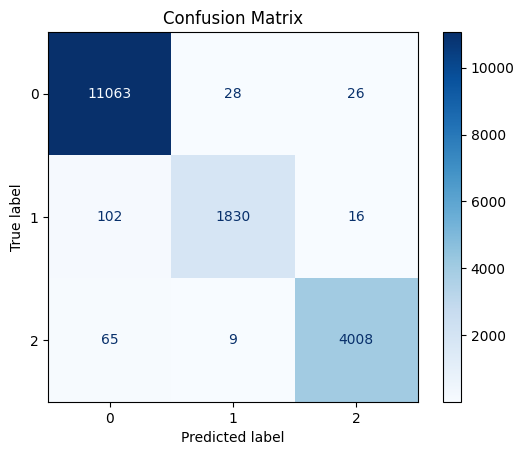

In [305]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

feature importance


In [306]:
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_
print(feature_importances)

[0.05779466 0.04886506 0.15631124 0.14159485 0.09245225 0.10203663
 0.16066464 0.14052435 0.0997563 ]


['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'plate', 'MJD']


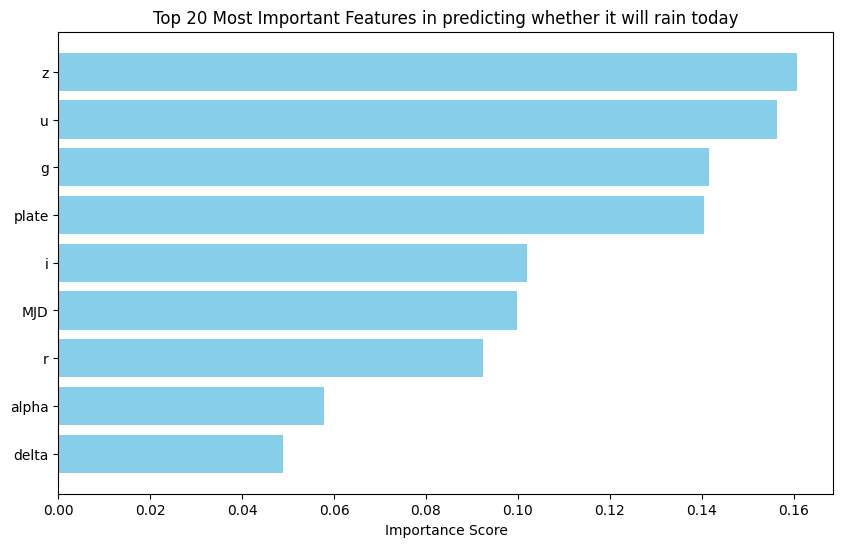

In [307]:
# Combine numeric and categorical feature names
feature_names = numeric_features 
print(feature_names)

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

N = 20  # Change this number to display more or fewer features
top_features = importance_df.head(N)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

modeling wihout redshift